In [1]:
library(goldmine)
library(parallel)
library(dplyr)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘pac

### Prepare PolyASite v.2 peak reference

In [5]:
## PolyASite v.2.0

##### polyADb
chr<-paste0('chr',1:22)
chr<-c(chr,'chrX','chrY')

polyadb_fpath_hg38<-'~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/atlas.clusters.2.0.GRCh38.96.tsv'
pdb_hg38 <- fread(polyadb_fpath_hg38)
pdb_hg38$chrom<-paste0('chr',pdb_hg38$chrom)
pdb_hg38<-pdb_hg38[pdb_hg38$chrom %in% chr,]

# TE, terminal exon; EX, exonic; IN, intronic; DS, 1,000 nt downstream of an annotated terminal exon
# AE, anti-sense to an exon; AI, anti-sense to an intron; AU, 1,000 nt upstream in anti-sense direction of a transcription start site; IG, intergenic
source('~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/Scripts/urothelial/3_peak_ref_cleanup/scPASU_functions.R')
pdb_hg38 <- pdb_hg38[,c(1,2,3,6)]
colnames(pdb_hg38) <- c('chr','start','end','strand')
pdb_gr <- makeGRanges(pdb_hg38, strand = T)
pdb_gr<-reduce(pdb_gr,min.gapwidth=1)
pdb_hg38 <- as.data.frame(pdb_gr)
pdb_hg38$width <- NULL
colnames(pdb_hg38) <- c('chr','start','end','strand')

pdb_gr <- makeGRanges(pdb_hg38,strand=T)
pdb_gr$polya <- 'polya'
seqlevels(pdb_gr) <- chr
pdb_gr <- pdb_gr[order(pdb_gr)]
pdb_gr$peakID <- paste0('peak_',1:length(pdb_gr))

turef <- readRDS('/Users/ninhle/Desktop/Research/mcast_analyses/genes.rds')
jtu <- joinTus_peaks(pdb_gr,turef)

save(jtu,pdb_hg38,turef,file='~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/atlas.clusters.2.0.GRCh38.96_minGapwidth1_jtu.rds')

load('~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/atlas.clusters.2.0.GRCh38.96_minGapwidth1_jtu.rds')

# Create Peak reference with all relevant columns merged after TU assignment #
cat('Add other relevant cols \n')

jtu$join<-as.data.frame(jtu$join)
# Remove multi-TU peaks
cat('Remove peaks that are assigned to multiple TUs, i.e. non-unique_peak TUs \n')
r1<-which(jtu$join$unique_peak==FALSE)

if(length(r1)!=0) {
  tu_tab<-jtu$join[-r1,] 
}else{
  tu_tab<-jtu$join
}

# Unique TU (TU contains only peaks assigned uniquely to TU) status is determined before removing peaks with unique_peak==FALSE so there can still be FALSE unique_tu peaks left

# Create peak per TU count
tu_peak<-jtu$join %>% dplyr::select(peak,tu) %>% group_by(tu) %>% tally()

# Peaks (saved from merging all peaks from MACS2 output)
peaks<-as.data.frame(jtu$polya_peaks)
found<-match(tu_tab$peak,peaks$peakID)
cat(paste(length(found),'peaks overlap uniquely with the reference TU. Only move forward with these peaks \n'))
matched_peaks<-peaks[found,]

# Sort all tables
# tu_tab<-tu_tab[mixedorder(tu_tab$peak),] Peak numbering, in this new approach, is not necessarily reflective of their relative position
# matched_peaks<-matched_peaks[mixedorder(matched_peaks$peakID),]

# Now lets transfer peak info to TU table
stopifnot(identical(tu_tab$peak,matched_peaks$peakID)) # TRUE

tu_tab$chr<-matched_peaks$seqnames
tu_tab$start<-matched_peaks$start
tu_tab$end<-matched_peaks$end
tu_tab$strand<-matched_peaks$strand
tu_tab$gene<-strsplit(tu_tab$tu_anno,split=':') %>% sapply(.,'[[',2)

# Also transfer other info for future use. This table can then serve as comprehensive features table

tu_tab$pr_chr<-matched_peaks$seqnames
tu_tab$pr_start<-matched_peaks$start
tu_tab$pr_end<-matched_peaks$end
tu_tab$pr_strand<-matched_peaks$strand
tu_tab$pr_width<-matched_peaks$end - matched_peaks$start
tu_tab$peakID<-matched_peaks$peakID

# Now add peakID to tu annotation column (multi peak TU will look like TU1:gene:P1, TU1:gene:P2 and TU1:gene:P3 while single peak TU will look like TU2:gene:P0)
cat('Sorting peaks by genomic coordinates before peak numbering \n')
tu_tab <- makeGRanges(tu_tab, strand = T)
seqlevels(tu_tab) <- chr
tu_tab <- tu_tab[order(tu_tab)]
tu_tab <- as.data.frame(tu_tab)
tu_tab$width <- NULL
colnames(tu_tab)[1] <- 'chr'

# Get TU count
tu_count<-tu_tab %>% group_by(tu) %>% tally()

# Sort
tu_count<-tu_count[order(tu_count$n),]

#Single peak per TU
single<-which(tu_count$n==1)
s<-match(tu_count$tu[single],tu_tab$tu)
single_tu<-tu_tab[s,]
cat(paste(single_tu$tu %>% unique() %>% length(),'TUs have only one peaks. These peaks are hence annotated P0 \n'))
single_tu$final_annotation<-paste0(single_tu$tu_anno,':P0')

# Multi peak TU -
multi_tu<-tu_tab[-s,]

# Split by strand
multi_tu_p<-multi_tu[multi_tu$strand=='+',]
multi_tu_m<-multi_tu[multi_tu$strand=='-',]

# Now add final annotation col
multi_tu_p2<-create_final_annotation_col(multi_tu_p)
multi_tu_m2<-create_final_annotation_col(multi_tu_m,is_minus=TRUE)

# Merge plus and minus strand
multi_tu2<-rbind(multi_tu_p2,multi_tu_m2)

# Add P0 genes back to ref
merged_tu3<-rbind(single_tu,multi_tu2)

# Save
merged_tu3<-merged_tu3 %>% as.data.frame()

write.table(merged_tu3,'~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/atlas.clusters.2.0.GRCh38.96_minGapwidth1_peak_universe_updated.txt',
            sep='\t',row.names=FALSE,col.names=TRUE,quote=FALSE)

turef_flank_updated <- update_flank(merged_tu3,turef,save=FALSE)

saveRDS(turef_flank_updated,'~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/atlas.clusters.2.0.GRCh38.96_minGapwidth1_genes_flankupdated_new.rds')

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following object is masked from ‘package:data.table’:

    melt


The following objects are masked from ‘package:S4Vectors’:

    expand, rename



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA


Loading required package: BiocParallel

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following objects are ma

Retain only polyA supported peaks. This step should be redundant because the input peaks are only polyA peaks from the earlier step 
Annotate peaks based on which TU or flanking region they lie in 
Assigning TU anno 
Assigning TU anno from flank 
For peaks that lie at the junction of a TU and its 3 flanking region, count them as part of the TU body 
Create data table 
Check if a peak is assigned to only one TU, i.e. unique_peak and if a TU contains only unique peaks, i.e. unique_tu 
Add other relevant cols 
Remove peaks that are assigned to multiple TUs, i.e. non-unique_peak TUs 
356376 peaks overlap uniquely with the reference TU. Only move forward with these peaks 
Sorting peaks by genomic coordinates before peak numbering 
4573 TUs have only one peaks. These peaks are hence annotated P0 
Modify the flank regions so that it ends at the most downstream peak. If no peaks are found within the flank regions and the no peak overfloods the TU border, the regions are deleted.


### Overlap analysis between scPASU Ureter peak reference and PolyASite v.2 peak reference

In [6]:
f<- '~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/urothelial_final_peak_universe_updated.txt'
p<- '~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/atlas.clusters.2.0.GRCh38.96_minGapwidth1_peak_universe_updated.txt'
scpasu <-fread(f,header=TRUE)
polyasite2 <- fread(p, header=TRUE)
polyasite2_filtered <- polyasite2[polyasite2$tu %in% scpasu$tu,]

In [ ]:
# Make GRanges obj
colnames(scpasu)[2:3] <- paste0('peak_',colnames(scpasu)[2:3])
colnames(scpasu)[17:18] <- c('start','end')
scpasu_gr <- makeGRanges(scpasu,strand=T)
polyasite2_gr <- makeGRanges(polyasite2_filtered,strand=T)
ovl <- findOverlaps(scpasu_gr,polyasite2_gr) %>% as.data.frame()
ovl_spl <- split(ovl,ovl$queryHits)

# Annotate overlaps with precision/recall
scpasu_ovlannot <- mclapply(ovl_spl,function(x){
  qh <- unique(x$queryHits) %>% as.integer()
  sh <- x$subjectHits %>% as.integer()
  
  sp <- as.data.frame(scpasu_gr[qh])
  pas2 <- as.data.frame(polyasite2_gr[sh])
  # Filter for matching genes only
  pas2 <- pas2[pas2$tu %in% sp$tu,]
  if (nrow(pas2)!=0){
    ovl_annot <- data.frame(tu = sp$tu, scpasu_prsite = sp$final_annotation, chr = sp$seqnames, 
                            scpasu_prstart = sp$start, scpasu_prend = sp$end, scpasu_strand = sp$strand, scpasu_prwidth = sp$width,
                            polyasite2_start = pas2$start, polyasite2_end = pas2$end, polyasite2_strand = pas2$strand, polyasite2_prwidth = pas2$width)
    ovl_annot$numnuc_ovl <- apply(ovl_annot,1,function(x){
      ovl_range <- c(max(as.integer(x[c(4,8)])),
                     min(as.integer(x[c(5,9)])))
      numnuc_ovl <- ovl_range[2]-ovl_range[1]+1
      return(numnuc_ovl)
    })
    
    ovl_annot$precision <- ovl_annot$numnuc_ovl/ovl_annot$scpasu_prwidth
    ovl_annot$recall <- ovl_annot$numnuc_ovl/ovl_annot$polyasite2_prwidth
    ovl_annot$avg_precision <- mean(ovl_annot$precision)
    ovl_annot$avg_recall <- mean(ovl_annot$recall)
    
    return(ovl_annot)
  }
},mc.cores = 6)

# Check for strand mismatches
strandmismatch <- lapply(scpasu_ovlannot, function(x){
  strand_check <- x$polyasite2_strand!=x$scpasu_strand
  if (any(strand_check)){
    print(x)
    return(x)
  }
})

# Summarize overlap annotation
scpasu_ovlannot_df <- lapply(scpasu_ovlannot, function(x){
  summary <- x[1,!(colnames(x) %in% c('polyasite2_start','polyasite2_end','polyasite2_strand','polyasite2_prwidth','numnuc_ovl','precision','recall'))]
  return(summary)
})
scpasu_ovlannot_df <- do.call('rbind',scpasu_ovlannot_df)
# 21777/32227 peaks overlap with some polyAsite of the right gene/tu

,tu,scpasu_prsite,chr,scpasu_prstart,scpasu_prend,scpasu_strand,scpasu_prwidth,avg_precision,avg_recall
,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<int>,<dbl>,<dbl>
1,TU10,TU10:LINC01409:P1,chr1,789672,789845,+,174,0.01149425,1.0000000
3,TU100,TU100:PER3:P1,chr1,7788240,7788925,+,686,0.03206997,1.0000000
4,TU100,TU100:PER3:P2,chr1,7844980,7845183,+,204,0.17156863,0.8974359
5,TU10000,TU10000:WDR70:P0,chr5,37752495,37752675,+,181,0.10635359,0.9610119
6,TU10006,TU10006:LIFR-AS1:P0,chr5,38557674,38557955,+,282,0.08510638,1.0000000
7,TU10009,TU10009:OSMR:P1,chr5,38886415,38886772,+,358,0.05935754,1.0000000


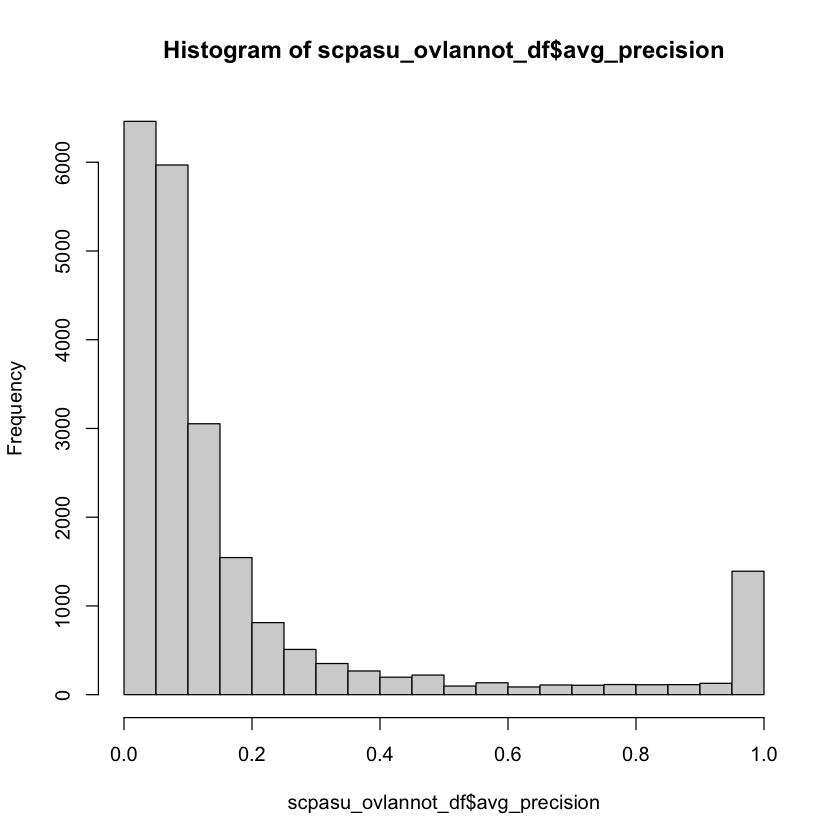

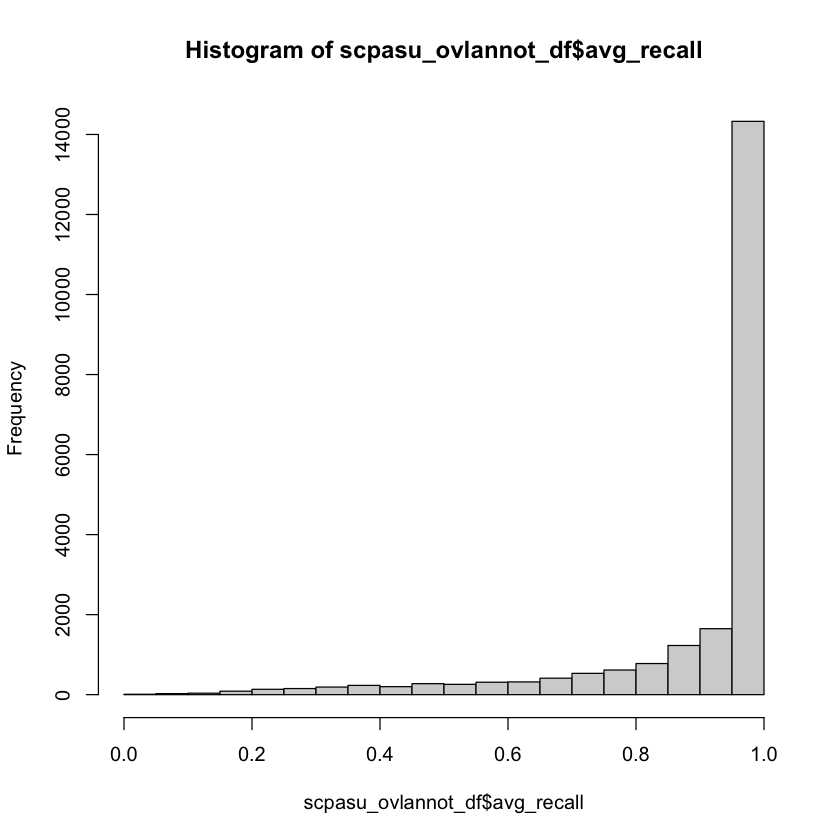

In [9]:
head(scpasu_ovlannot_df)
hist(scpasu_ovlannot_df$avg_precision)
hist(scpasu_ovlannot_df$avg_recall)

In [17]:
# Non-overlap
scpasu_nonovl <- scpasu[!(scpasu$final_annotation %in% scpasu_ovlannot_df$scpasu_prsite),]
# Non-overlap because TU not in database
scpasu_nonovl_notu <- scpasu_nonovl[!(scpasu_nonovl$tu %in% polyasite2_filtered$tu),]
num_nonovl_notu <- nrow(scpasu_nonovl_notu)
message('Number of non-overlap but TU not in database: ', num_nonovl_notu)
# 842 PR sites
# Continue with non-overlap but TU in database
scpasu_nonovl <- scpasu_nonovl[(scpasu_nonovl$tu %in% polyasite2_filtered$tu),]
# 9608 PR sites
message('Number of non-overlap but TU in database: ', nrow(scpasu_nonovl))

Number of non-overlap but TU not in database: 842

Number of non-overlap but TU in database: 9608



In [18]:
message('Number of overlapping PR sites: ', nrow(scpasu_ovlannot_df))
message('Percent overlapping: ', round((nrow(scpasu_ovlannot_df)/(nrow(scpasu)-num_nonovl_notu)*100),2), '%')

Number of overlapping PR sites: 21777

Percent overlapping: 69.39%



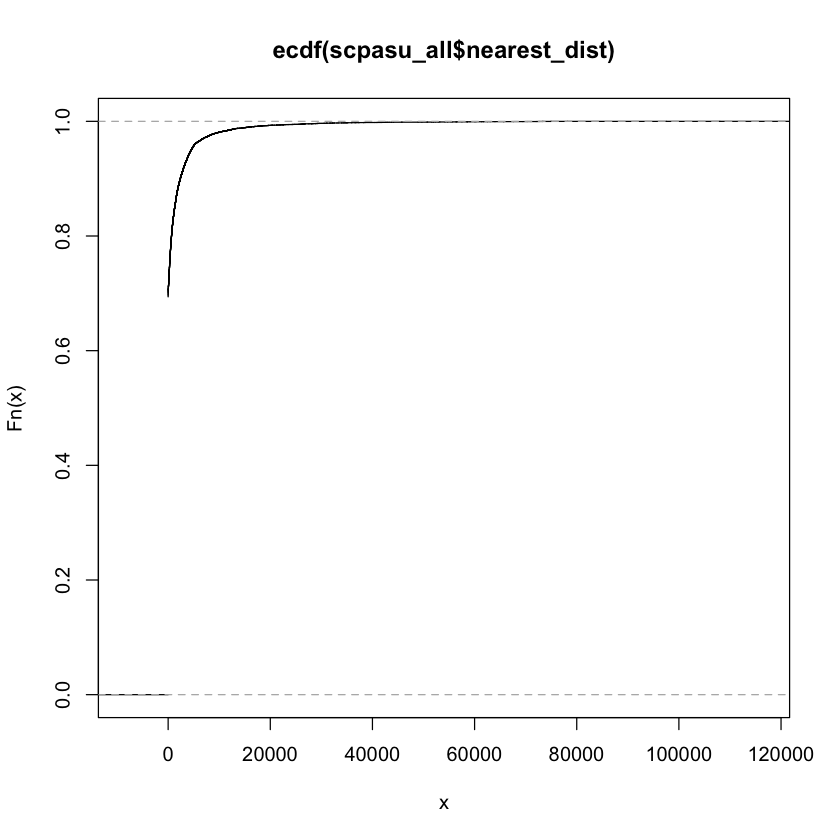

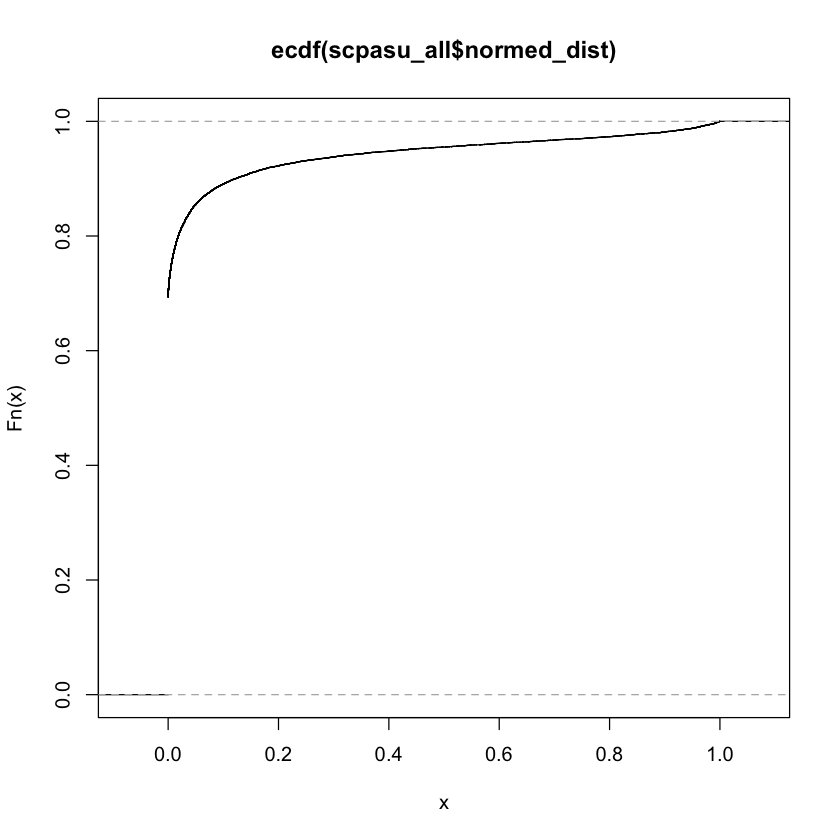

In [ ]:
# For non-overlap PR sites, find nearest polyAsite v2 site within same TU
nearest_polyasitev2 <- apply(scpasu_nonovl,1,function(x){
  tu_idx <- which(colnames(scpasu_nonovl)=='tu')
  start_idx <- which(colnames(scpasu_nonovl)=='start')
  end_idx <- which(colnames(scpasu_nonovl)=='end')
  polyasite2_coordinates <- polyasite2[polyasite2$tu==x[tu_idx],c('start','end')] %>% unlist() %>% as.integer()
  dist_from_start <- abs(as.integer(x[start_idx])-polyasite2_coordinates)
  dist_from_end <- abs(as.integer(x[end_idx])-polyasite2_coordinates)
  dist <- c(dist_from_start,dist_from_end)
  names(dist) <- rep(polyasite2$final_annotation[polyasite2$tu==x[tu_idx]],times = 4)
  min_dist <- min(dist)
  nearest_prsite <- names(dist)[dist==min_dist] %>% unique() %>% paste0(collapse=',')
  all_coordinates <- c(unname(polyasite2_coordinates),x[c(start_idx,end_idx)]) %>% as.integer()
  range <- max(all_coordinates)-min(all_coordinates)+1
  return(c(min_dist,nearest_prsite,range))
}) %>% t() %>% as.data.frame()
colnames(nearest_polyasitev2) <- c('nearest_dist','nearest_prsite','range')
nearest_polyasitev2$nearest_dist <- as.integer(nearest_polyasitev2$nearest_dist)
nearest_polyasitev2$range<- as.integer(nearest_polyasitev2$range)
scpasu_nonovl <- cbind(scpasu_nonovl,nearest_polyasitev2)
# Normalize distance
scpasu_nonovl$normed_dist <- scpasu_nonovl$nearest_dist/scpasu_nonovl$range

#
scpasu_ovl <-scpasu[scpasu$final_annotation %in% scpasu_ovlannot_df$scpasu_prsite,]
scpasu_ovl$nearest_dist <- 0
scpasu_ovl$nearest_prsite <- NA
scpasu_ovl$range <- NA
scpasu_ovl$normed_dist <- 0
scpasu_all <- rbind(scpasu_ovl,scpasu_nonovl)

plot(ecdf(scpasu_all$nearest_dist))
plot(ecdf(scpasu_all$normed_dist))

70%    80%    90%    95%   100% 
     9    660   2381   4532 108022

70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 
  9  50 118 169 226 292 354 418 495 575 660

80%     81%     82%     83%     84%     85%     86%     87%     88%     89% 
 660.00  758.00  867.00  985.00 1132.56 1289.00 1462.00 1630.08 1834.92 2087.28 
    90% 
2381.00

Proportion of PR sites within 1kb: 83.11%

Proportion of PR sites within 50bp: 70.99%



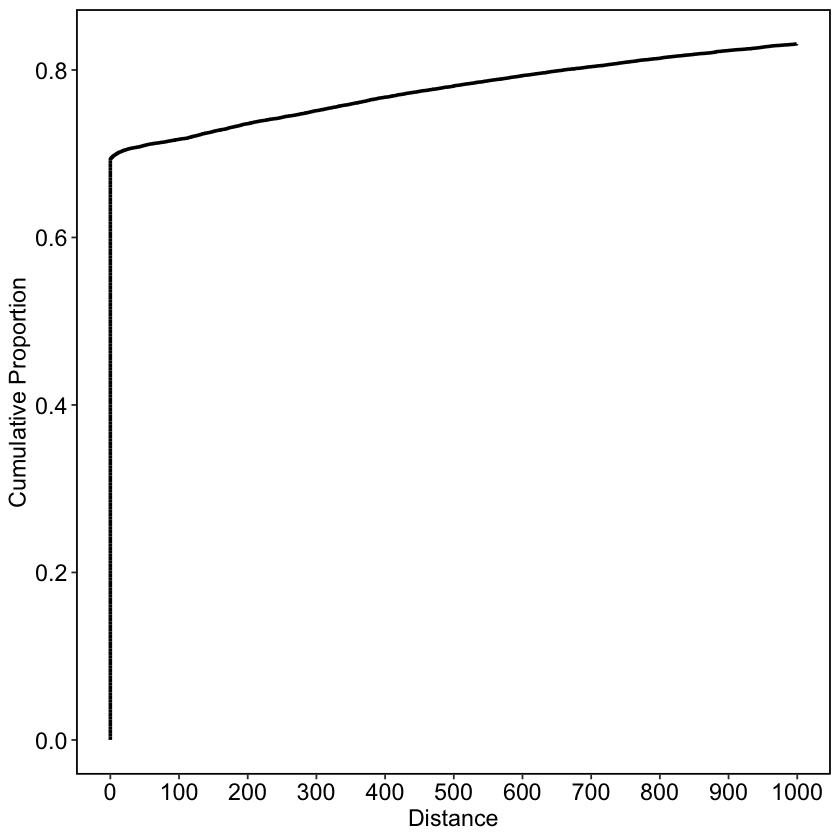

In [23]:
# Quantiles of nearest distances 
quantile(scpasu_all$nearest_dist, probs = c(0.7,0.8,0.9,0.95,1.0))
quantile(scpasu_all$nearest_dist, probs = seq(0.7,0.8,0.01))
quantile(scpasu_all$nearest_dist, probs = seq(0.8,0.9,0.01))

message('Proportion of PR sites within 1kb: ', round((sum(scpasu_all$nearest_dist < 1000)/nrow(scpasu_all))*100,2), '%')
message('Proportion of PR sites within 50bp: ', round((sum(scpasu_all$nearest_dist < 50)/nrow(scpasu_all))*100,2), '%')

# Zoom in at 1kb, tick mark for every 100 x-axis
cumulative_data <- scpasu_all %>% arrange(nearest_dist) %>%
  mutate(cumulative_prob = seq_along(nearest_dist) / n()) 
cumulative_data_filtered <- cumulative_data %>%
  filter(nearest_dist <= 1000)
p1 <- ggplot(cumulative_data_filtered, aes(x = nearest_dist, y = cumulative_prob)) + 
  geom_line(linewidth = 1) + labs(x = "Distance",y = "Cumulative Proportion") + 
  scale_x_continuous(breaks = seq(0,1000,100)) +
  theme(axis.text = element_text(colour = "black", size = 14),
        axis.title = element_text(size = 14),
        panel.background = element_blank(), 
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
p1

# ggsave('u10_uro_cumulative_proportion_distance_from_polyasitev2db.png', width = 8, height = 8, units = 'in', p1)